## Crime study
We have a dataset based on the crimes happening in Chicago. The goal in this notebook is to be able to predict a crime in the future based on the data that we have. This problem is an interesting problem because it is based on time-series. The data depends on time therefore we have to be careful about sepcial events like covid or seasonality that can impact the results. 

In [49]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 0. Import the dataset
file_path = "./Dataset.csv"
crime_data = pd.read_csv(file_path, low_memory=False)

# 1. Data Preprocessing
print("The data has {} rows and {} columns.".format(crime_data.shape[0], crime_data.shape[1]))
print("\n\n",crime_data.head())

The data has 1048575 rows and 22 columns.


          ID Case Number                    Date                   Block  IUCR  \
0  11646166    JC213529  09/01/2018 12:01:00 AM   082XX S INGLESIDE AVE  0810   
1  11645836    JC212333  05/01/2016 12:25:00 AM     055XX S ROCKWELL ST  1153   
2  11449702    JB373031  07/31/2018 01:30:00 PM  009XX E HYDE PARK BLVD  2024   
3  11643334    JC209972  12/19/2018 04:30:00 PM  056XX W WELLINGTON AVE  1320   
4  11645527    JC212744  02/02/2015 10:00:00 AM      069XX W ARCHER AVE  1153   

         Primary Type                          Description  \
0               THEFT                            OVER $500   
1  DECEPTIVE PRACTICE  FINANCIAL IDENTITY THEFT OVER $ 300   
2           NARCOTICS                  POSS: HEROIN(WHITE)   
3     CRIMINAL DAMAGE                           TO VEHICLE   
4  DECEPTIVE PRACTICE  FINANCIAL IDENTITY THEFT OVER $ 300   

  Location Description Arrest Domestic  ...  Ward  Community Area  FBI Code  \
0            RES

We observe that the dataset has a lot of data. In order to simplify it, we will first drop some values and fit some others in order to obtain a more process-friendly dataset.

In [ ]:
# Drop unnecessary columns and Nan filled columns
crime_data = crime_data.drop(columns =["X Coordinate","Y Coordinate","Updated On","Latitude","Longitude","Location"])


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year
0,11646166,JC213529,09/01/2018 12:01:00 AM,082XX S INGLESIDE AVE,0810,THEFT,OVER $500,RESIDENCE,False,True,631.0,6.0,8.0,44.0,06,2018.0
1,11645836,JC212333,05/01/2016 12:25:00 AM,055XX S ROCKWELL ST,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,False,False,824.0,8.0,15.0,63.0,11,2016.0
2,11449702,JB373031,07/31/2018 01:30:00 PM,009XX E HYDE PARK BLVD,2024,NARCOTICS,POSS: HEROIN(WHITE),STREET,True,False,233.0,2.0,5.0,41.0,18,2018.0
3,11643334,JC209972,12/19/2018 04:30:00 PM,056XX W WELLINGTON AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2514.0,25.0,31.0,19.0,14,2018.0
4,11645527,JC212744,02/02/2015 10:00:00 AM,069XX W ARCHER AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,OTHER,False,False,811.0,8.0,23.0,56.0,11,2015.0


Now that we have a smaller dataset, we will focus on the type of crime type and we will encode them

In [51]:
# 1. Label encode target
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
crime_data['Primary_Type_Label'] = le.fit_transform(crime_data['Primary Type'])

print(crime_data['Primary_Type_Label'])

0          30
1           9
2          18
3           6
4           9
           ..
1048570    32
1048571    32
1048572    32
1048573    32
1048574    32
Name: Primary_Type_Label, Length: 1048575, dtype: int32


Now that we encoded the crimes, we want to work on the dates to take into account the seasonality of the times series

In [52]:
# 2. Select features
# Convert 'Date' column to datetime
crime_data['Date'] = pd.to_datetime(crime_data['Date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

crime_data = crime_data.dropna(subset=['Date']) # Drop invalid rows 

crime_data['Year'] = crime_data['Date'].dt.year
crime_data['Month'] = crime_data['Date'].dt.month
crime_data['Day'] = crime_data['Date'].dt.day
crime_data['DayOfWeek'] = crime_data['Date'].dt.dayofweek
crime_data['Hour'] = crime_data['Date'].dt.hour
crime_data['IsWeekend'] = crime_data['DayOfWeek'].isin([5, 6]).astype(int)
crime_data['Date'] = pd.to_datetime(crime_data[['Year', 'Month', 'Day']])

crime_data['Hour_sin'] = np.sin(2 * np.pi * crime_data['Hour'] / 24) # Cyclic encoding to avoid discontinuity
crime_data['Hour_cos'] = np.cos(2 * np.pi * crime_data['Hour'] / 24)

crime_data['Month_sin'] = np.sin(2 * np.pi * crime_data['Month'] / 12)
crime_data['Month_cos'] = np.cos(2 * np.pi * crime_data['Month'] / 12)

crime_data['DayOfWeek_sin'] = np.sin(2 * np.pi * crime_data['DayOfWeek'] / 7)
crime_data['DayOfWeek_cos'] = np.cos(2 * np.pi * crime_data['DayOfWeek'] / 7)


# Day is an ordinal counter when DayOfWeek captures seasonality only
feature_cols = [
    'Year', 'Month_sin', 'Month_cos', 'Day', 'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'IsWeekend', 
    'District', 'Ward', 'Community Area', 
    'Location Description', 'Domestic', 'Arrest'
]

crime_counts = crime_data['Primary Type'].value_counts().sort_values(ascending=False)
print(crime_counts) 

Primary Type
THEFT                                21004
DECEPTIVE PRACTICE                   18810
NARCOTICS                            12469
BATTERY                               5851
CRIMINAL DAMAGE                       4571
OTHER OFFENSE                         4277
OFFENSE INVOLVING CHILDREN            3797
MOTOR VEHICLE THEFT                   3091
ASSAULT                               2064
SEX OFFENSE                           1802
BURGLARY                              1680
ROBBERY                               1479
CRIM SEXUAL ASSAULT                   1458
CRIMINAL TRESPASS                     1011
CRIMINAL SEXUAL ASSAULT                823
PROSTITUTION                           668
WEAPONS VIOLATION                      519
PUBLIC PEACE VIOLATION                 223
LIQUOR LAW VIOLATION                   132
STALKING                               103
GAMBLING                                96
ARSON                                   86
INTERFERENCE WITH PUBLIC OFFICER        7

We remark that the dataset is not cleaned yet, some categories appear multiple times with different casing or spaces so the previous encoding is not completley successful. We work on that point in the following part.

In [53]:
# 2.1. Clean data
crime_data['Primary Type'] = (
    crime_data['Primary Type']
    .str.strip()                     # remove leading/trailing spaces
    .str.upper()                     # make consistent casing
    .str.replace(r'\s+', ' ', regex=True)  # collapse multiple spaces
)

crime_mapping = {
   
    'THEFT': 'PROPERTY CRIME',
    'BURGLARY': 'PROPERTY CRIME',
    'ROBBERY': 'PROPERTY CRIME',
    'MOTOR VEHICLE THEFT': 'PROPERTY CRIME',
    'CRIMINAL DAMAGE': 'PROPERTY CRIME',
    'ARSON': 'PROPERTY CRIME',
    'CRIMINAL TRESPASS': 'PROPERTY CRIME',

    'DECEPTIVE PRACTICE': 'FRAUD & ECONOMIC CRIME',
    'FORGERY': 'FRAUD & ECONOMIC CRIME',

    'BATTERY': 'VIOLENT CRIME',
    'ASSAULT': 'VIOLENT CRIME',
    'HOMICIDE': 'VIOLENT CRIME',
    'KIDNAPPING': 'VIOLENT CRIME',
    'STALKING': 'VIOLENT CRIME',
    'INTIMIDATION': 'VIOLENT CRIME',

    'NARCOTICS': 'DRUG OFFENSE',
    'OTHER NARCOTIC VIOLATION': 'DRUG OFFENSE',

    'DOMESTIC VIOLENCE': 'OFFENSE INVOLVING CHILDREN',

    'WEAPONS VIOLATION': 'WEAPONS OFFENSE',
    'CONCEALED CARRY LICENSE VIOLATION': 'WEAPONS OFFENSE',

    'PUBLIC PEACE VIOLATION': 'PUBLIC DISTURBANCE',
    'INTERFERENCE WITH PUBLIC OFFICER': 'PUBLIC DISTURBANCE',
    'GAMBLING': 'PUBLIC DISTURBANCE',
    'LIQUOR LAW VIOLATION': 'PUBLIC DISTURBANCE',
    'RITUALISM': 'PUBLIC DISTURBANCE',
    'OBSCENITY': 'PUBLIC DISTURBANCE',
    'PUBLIC INDECENCY': 'PUBLIC DISTURBANCE',

    'SEX OFFENSE': 'SEXUAL OFFENSE',
    'CRIM SEXUAL ASSAULT': 'SEXUAL OFFENSE',
    'CRIMINAL SEXUAL ASSAULT': 'SEXUAL OFFENSE',
    'PROSTITUTION': 'SEXUAL OFFENSE',

    'OTHER OFFENSE': 'OTHER',
    'NON-CRIMINAL': 'NON-CRIMINAL',
    'NON - CRIMINAL': 'NON-CRIMINAL',
    'NON-CRIMINAL (SUBJECT SPECIFIED)': 'NON-CRIMINAL',
}

crime_data['Crime Category'] = crime_data['Primary Type'].map(crime_mapping) # Apply mapping

print(crime_data)

data = crime_data[feature_cols + ['Crime Category']].dropna() # Group with feature columns and drop rows with NaN values

print(data)


              ID Case Number       Date                   Block  IUCR  \
0       11646166    JC213529 2018-09-01   082XX S INGLESIDE AVE  0810   
1       11645836    JC212333 2016-05-01     055XX S ROCKWELL ST  1153   
2       11449702    JB373031 2018-07-31  009XX E HYDE PARK BLVD  2024   
3       11643334    JC209972 2018-12-19  056XX W WELLINGTON AVE  1320   
4       11645527    JC212744 2015-02-02      069XX W ARCHER AVE  1153   
...          ...         ...        ...                     ...   ...   
307829  13126234    JG323242 2023-06-28        005XX N CLARK ST  0820   
307830  13127172    JG324611 2023-06-28  010XX N Winchester Ave  0810   
307833  13121768    JG318030 2023-06-27     005XX N PESHTIGO CT  1153   
307837  13127195    JG324580 2023-06-28     015XX W ARDMORE AVE  0820   
307838  13126250    JG323470 2023-06-28   072XX S Lafayette Ave  0820   

              Primary Type                          Description  \
0                    THEFT                            OV

Now that we have a cleaner dataset, we proceed to encode the dataset

In [56]:
le_grouped = LabelEncoder() # Second encoding to avoid overwriting

# 3. Encode categoricals
for col in ['District', 'Ward', 'Community Area', 'Location Description']:
    data[col] = data[col].astype('category')

print(data['Crime Category'].value_counts()) # Check the distribution of the target variable
print("\n")

data['Crime_Category_Label'] = le_grouped.fit_transform(data['Crime Category']) # Label encoding
for i, label in enumerate(le_grouped.classes_):
    print(f"{i}: {label}")



Crime Category
PROPERTY CRIME            28674
FRAUD & ECONOMIC CRIME    14673
DRUG OFFENSE              11190
VIOLENT CRIME              5964
SEXUAL OFFENSE             4468
OTHER                      3727
PUBLIC DISTURBANCE          456
WEAPONS OFFENSE             442
NON-CRIMINAL                  9
Name: count, dtype: int64


0: DRUG OFFENSE
1: FRAUD & ECONOMIC CRIME
2: NON-CRIMINAL
3: OTHER
4: PROPERTY CRIME
5: PUBLIC DISTURBANCE
6: SEXUAL OFFENSE
7: VIOLENT CRIME
8: WEAPONS OFFENSE


We see that compared to before, we have an amount of 9 different type of crimes instead of 32.

c:\Users\nasir\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nasir\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nasir\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

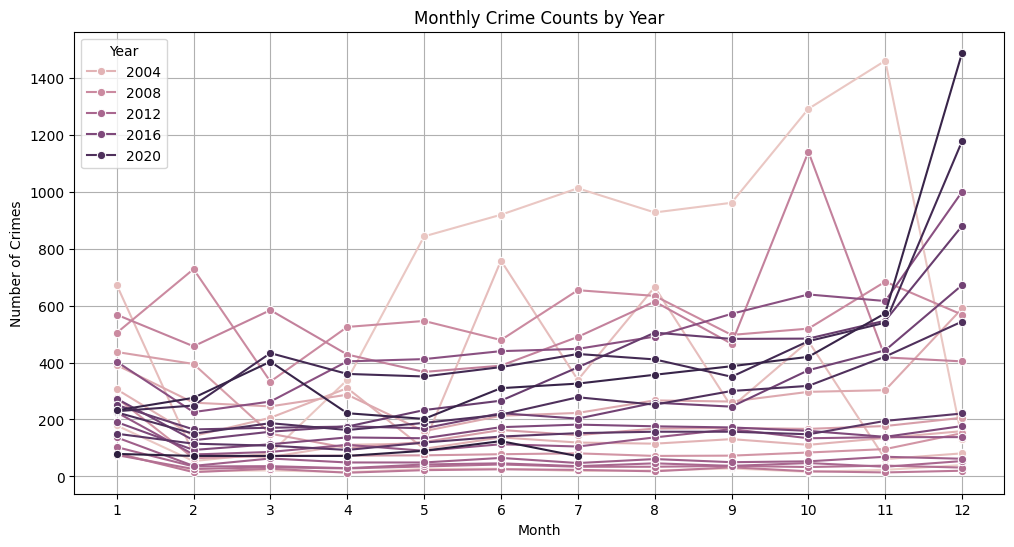

In [ ]:
data2 = data.copy()
data2["Month"] = crime_data["Month"]  # Copy over Month if it's extracted

monthly_counts = data2.groupby(['Year', 'Month']).size().reset_index(name='Crime Count')

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_counts, x='Month', y='Crime Count', hue='Year', marker='o')

plt.title('Monthly Crime Counts by Year')
plt.xlabel('Month')
plt.ylabel('Number of Crimes')
plt.xticks(range(1, 13))
plt.legend(title='Year')
plt.grid(True)
plt.show()

We see that we have a lot more crime happening at the end of the year compared to the beginning of the year. However, throughout the years crime rate is also declinign. A classic assumption in Machine Learning is to use a linear regression to try to solve the problem at first.
## Linear Regression
In this Linear regression, we will only try to see if we can accurately predict the different type of crime that is going to happen in a month.

# LGBM Classifier 

In [55]:
# 4. Train/Test split
train_data = data[data['Year'] < 2020]
test_data = data[data['Year'] >= 2020]

X_train = train_data[feature_cols]
y_train = train_data['Crime_Category_Label']
X_test = test_data[feature_cols]
y_test = test_data['Crime_Category_Label']  

# 5. Train model
model = LGBMClassifier(
    objective='multiclass',
    num_class=len(le_grouped.classes_),
    class_weight='balanced',
    n_estimators=300,
    learning_rate=0.1,
    max_depth=10,
    random_state=42
)
model.fit(X_train, y_train)

# 6. Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le_grouped.classes_))

cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=le_grouped.classes_, 
            yticklabels=le_grouped.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: Domestic: object, Arrest: object